In [32]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

In [2]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True
/job:localhost/replica:0/task:0/device:GPU:0


2024-02-10 16:49:48.413055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:49:48.442269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:49:48.442531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [33]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_HLT = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa']

In [34]:
# Read EB data22 file

with h5py.File('../../../../ntuples/AOD_EB_ntuples_02-10-2024.h5', 'r') as hf:
    jets = hf['HLT_jets'][:]
    electrons = hf['electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    muons = hf['muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    photons = hf['photons'][:]
    MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [35]:
print(jets.shape)

(1019220, 10, 4)


In [36]:
# Collect only events that passed any of our unprescaled L1 list, and concatenate. Remove E.

pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
pass_HLT_unprescaled = pass_HLT_unprescaled[pass_L1_idxs]
data = np.concatenate([jets[pass_L1_idxs], electrons[pass_L1_idxs], muons[pass_L1_idxs], photons[pass_L1_idxs], MET[pass_L1_idxs]], axis=1)
weights = EB_weights[pass_L1_idxs]
datasets.append(data[:, :, [0, 2, 3]])
pass_HLT.append(pass_HLT_unprescaled)

In [37]:
# Read MC data. Remove E.

filenames = ['HHbbttHadHad.h5', 
             'ZZ4lep.h5', 
             'Ztautau.h5', 
             'jjJZ4.h5', 
             'jjJZ2.h5', 
             'qqa.h5', 
             'HNL7p5_ctau1_eemu.h5',
             'Zprime2EJs.h5',
             'HAHMggfZdZd2l2nu.h5']
data_path = '../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]])
        pass_HLT.append(pass_HLT_unprescaled[0:min(len(combined_data), 100000)])

In [38]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [39]:
"""Normalize pt """
for i, data in enumerate(datasets):
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [40]:
"""Shuffle objects"""
for data in datasets:
    for event in data:
        np.random.shuffle(event)

In [41]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (224294, 20, 3)
HHbbttHadHad: (20000, 20, 3)
ZZ4lep: (100000, 20, 3)
Ztautau: (100000, 20, 3)
jjJZ4: (100000, 20, 3)
jjJZ2: (100000, 20, 3)
qqa: (50000, 20, 3)


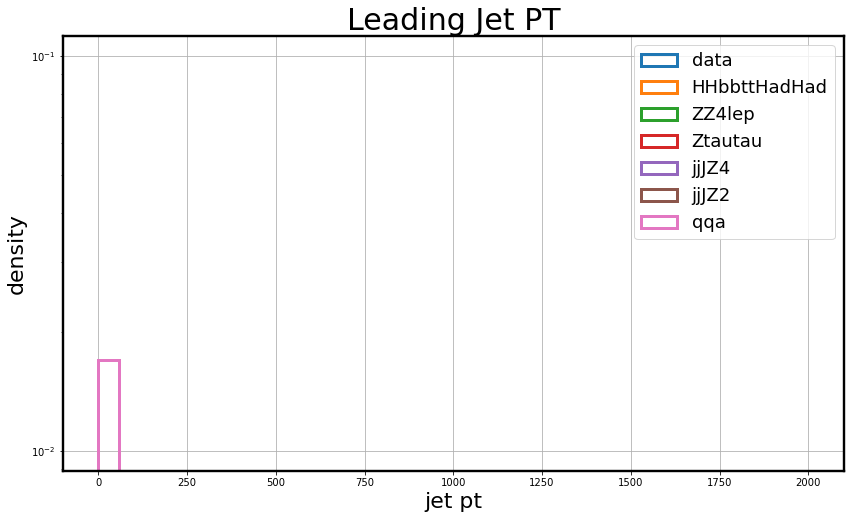

In [42]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, 0, 0]
    nonzero_pt = pt[pt > 0]

    if i==0:
        nonzero_weights = weights[pt > 0]
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)
    else:
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [43]:
# Flatten ndarrays for use in DNN

for i, data in enumerate(datasets):
    datasets[i] = np.reshape(data, newshape=(-1, 60))

for i, data in enumerate(datasets):
    print(f'{tags[i]}: {data.shape}')

data: (224294, 60)
HHbbttHadHad: (20000, 60)
ZZ4lep: (100000, 60)
Ztautau: (100000, 60)
jjJZ4: (100000, 60)
jjJZ2: (100000, 60)
qqa: (50000, 60)


In [44]:
def create_AE(input_dim, h_dim_1, h_dim_2, h_dim_3, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    #x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    #x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(z)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [46]:
# Make train, test, val splits

TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2

X_train, X_, weights_train, weights_, pass_HLT_train, pass_HLT_ = train_test_split(datasets[0], weights, pass_HLT[0], train_size=TRAIN_SIZE)
X_val, X_test, weights_val, weights_test, pass_HLT_val, pass_HLT_test = train_test_split(X_, weights_, pass_HLT_, train_size=0.5)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')

X_train: (134576, 60)
X_val: (44859, 60)
X_test: (44859, 60)


In [47]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
H_DIM_3 = 3
LATENT_DIM = 3
DNN_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, h_dim_3=H_DIM_3, latent_dim=LATENT_DIM)
DNN_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                1952      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 3)                 27        
                                                                 
 dense_9 (Dense)             (None, 8)                 32        
                                                                 
 dense_10 (Dense)            (None, 32)                288       
                                                                 
 dense_11 (Dense)            (None, 60)                1980

In [48]:
DNN_AE.compile(optimizer='adam', loss=loss_fn)

In [49]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [50]:
NUM_EPOCHS = 100
BATCH_SIZE = 1024

In [51]:
history = DNN_AE.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/100
132/132 [==============================] - 2s 7ms/step - loss: 1.3709 - val_loss: 1.2922 - lr: 0.0010
Epoch 2/100
132/132 [==============================] - 1s 4ms/step - loss: 1.2770 - val_loss: 1.2698 - lr: 0.0010
Epoch 3/100
132/132 [==============================] - 1s 4ms/step - loss: 1.2641 - val_loss: 1.2430 - lr: 0.0010
Epoch 4/100
132/132 [==============================] - 1s 4ms/step - loss: 1.2243 - val_loss: 1.2184 - lr: 0.0010
Epoch 5/100
132/132 [==============================] - 1s 5ms/step - loss: 1.2156 - val_loss: 1.2146 - lr: 0.0010
Epoch 6/100
132/132 [==============================] - 1s 5ms/step - loss: 1.2127 - val_loss: 1.2124 - lr: 0.0010
Epoch 7/100
132/132 [==============================] - 1s 5ms/step - loss: 1.2105 - val_loss: 1.2104 - lr: 0.0010
Epoch 8/100
132/132 [==============================] - 1s 4ms/step - loss: 1.2085 - val_loss: 1.2084 - lr: 0.0010
Epoch 9/100
132/132 [==============================] - 1s 4ms/step - loss: 1.2066 - val_

In [52]:
predictions = []
y_true = []


predictions.append(DNN_AE.predict(X_test))
y_true.append(X_test)

for i, data in enumerate(datasets):
    if i==0: continue

    y_true.append(data)
    predictions.append(DNN_AE.predict(data))

1563/1563 [==============================] - 2s 1ms/step


In [53]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [54]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [55]:
total_loss = []

for i, prediction in enumerate(predictions):
    total_loss.append(AD_score(y_true[i], prediction))

<Figure size 1296x720 with 0 Axes>

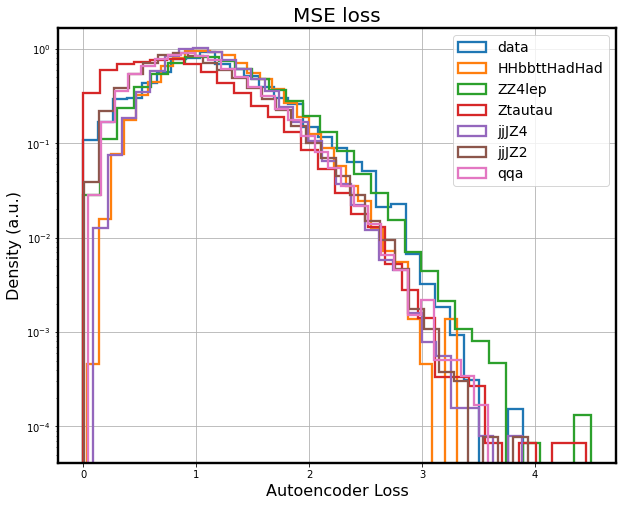

In [56]:
plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    if i==0:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_test)
    else:
        plt.hist(total_loss[i], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

data: TPR at FPR of 10^-4 is 0.0001 with threshold 3.3604


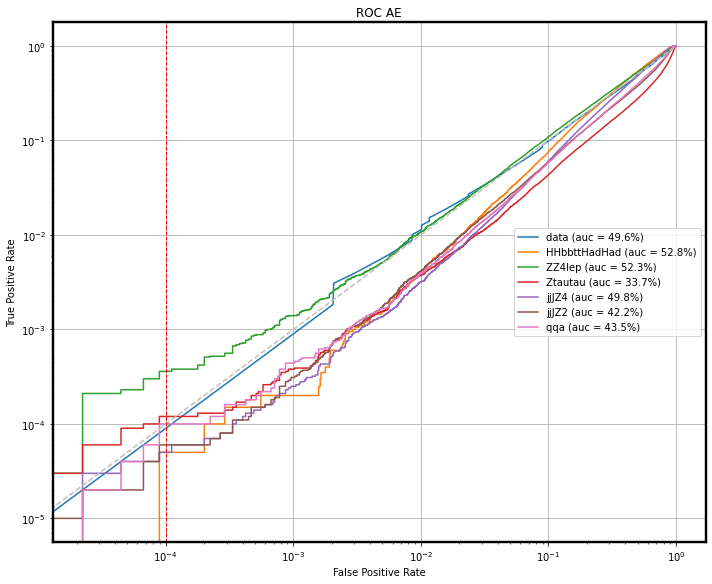

In [57]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))

for i, label in enumerate(tags):
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))
    
    # Include weights for the EB data and assign no weight (or equal weight) for the other dataset
    if i == 0:  # For the EB data
        sample_weights = np.concatenate((weights_test, np.ones_like(target_background)))
    else:  # For the MC datasets, assume equal weight
        sample_weights = np.concatenate((np.ones(total_loss[i].shape[0]), np.ones_like(target_background)))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==0: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        threshold = threshold_loss[idx]

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()

# Additional plot elements
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.0001, color='red', linestyle='dashed', linewidth=1)  # Threshold value
plt.title("ROC AE")
plt.show()

In [58]:
"""Print the HLT overlap (the percentage of events we found as anomalous that
are already being triggered by the HLT)"""

for i, tag in enumerate(tags):
    anomaly_idxs = (total_loss[i] > threshold)
    HLT_overlap = 0

    if i ==0:
        for a, h in zip(anomaly_idxs, pass_HLT_test):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)
    else:
        for a, h in zip(anomaly_idxs, pass_HLT[i]):
            if a==1 and h==1:
                HLT_overlap += 1
        HLT_overlap /= np.sum(anomaly_idxs)

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_test) / len(pass_HLT_test)}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

-----
data:
HLT overlap: 0.3333333333333333
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 6.687621213134488e-05
number of events that we tagged as anomalous: 3
-----
HHbbttHadHad:
HLT overlap: nan
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 0.0
number of events that we tagged as anomalous: 0
-----
ZZ4lep:
HLT overlap: 0.9666666666666667
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 0.0003
number of events that we tagged as anomalous: 30


/tmp/ipykernel_8499/3977479557.py:17: RuntimeWarning: invalid value encountered in long_scalars
  HLT_overlap /= np.sum(anomaly_idxs)


-----
Ztautau:
HLT overlap: 0.2
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 0.0001
number of events that we tagged as anomalous: 10
-----
jjJZ4:
HLT overlap: 1.0
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 4e-05
number of events that we tagged as anomalous: 4
-----
jjJZ2:
HLT overlap: 0.0
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 4e-05
number of events that we tagged as anomalous: 4
-----
qqa:
HLT overlap: 0.3333333333333333
percentage of events that passed some HLT trigger: 0.0326801756615172
percentage of events that we tagged as anomalous: 6e-05
number of events that we tagged as anomalous: 3


In [48]:
DNN_AE.save('../../trained_models/DNN_AE_norm_v1.keras')

***
<hr style="border:2px solid #F08080">

In [55]:
HLT_rate = np.sum(weights * pass_HLT[0]) / np.sum(weights)
print(f'HLT acceptance: {HLT_rate}')
print(f'HLT rejection: {1/HLT_rate}')

HLT acceptance: 0.01663002240942737
HLT rejection: 60.13221001031913
